# GreatApeT2T-G4s `notebook#4`
This jupyter notebook contains code snippets to generate:
 1. Plots for aligned vs unaligned specific pG4s in great apes repeats 
 2. -do- and functional categories

In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import pybedtools

## 1. Generate plots for aligned vs unaligned specific pG4s in great apes repeats 

In [2]:
# Load the all-unique and aligned unique G4s
alluniquedf = pd.read_csv('../datasets/pipelineOutputs/uniquehsaG.egs.gz', sep='\t', header=None, compression='gzip')
alignedUniquedf = pd.read_csv('../datasets/pipelineOutputs/alignedUniquehsaG.egs.gz', sep='\t', header=None, compression='gzip')

# Get the non-aligned unique G4s
nonAlignedUniquedf = pd.merge(alluniquedf, alignedUniquedf, how='left', indicator=True)
nonAlignedUniquedf = nonAlignedUniquedf[nonAlignedUniquedf['_merge'] == 'left_only']
nonAlignedUniquedf.drop(columns=['_merge'], inplace=True)

In [3]:
def splitIDsandarrange(df):
    ''' Split the IDs and arrange the columns '''
    dfOut = df[0].str.split('|', expand=True)
    dfOut.columns = ['species', 'chrom', 'start', 'strand', 'length', 'score']
    dfOut['species'] = dfOut['species'].astype(int)
    dfOut['start'] = dfOut['start'].astype(int)
    dfOut['length'] = dfOut['length'].astype(int)
    dfOut['end'] = dfOut['start'] + dfOut['length']
    dfOut.sort_values(by=['species','chrom', 'start'], inplace=True)
    dfOut['chrom'] = dfOut['chrom'].apply(lambda x: f'chr{x}')
    dfOut.drop(columns=['length'], inplace=True)
    dfOut.reset_index(drop=True, inplace=True)
    dfOut["dummy"] = '.'
    dfOut = dfOut[['species', 'chrom', 'start', 'end', 'dummy', 'score', 'strand']]
    return dfOut

In [4]:
speciesnos = {1: ['human','Homo_sapiens', 'human'],
              2: ['bonobo','Pan_paniscus', 'bonobo'],
              3: ['chimp','Pan_troglodytes', 'chimpanzee'],
              4: ['gorilla','Gorilla_gorilla', 'gorilla'],
              5: ['sorang','Pongo_abelii', 'S. orangutan'],
              6: ['borang','Pongo_pygmaeus', 'B. orangutan']}

In [5]:
alignedUniqueGQs = splitIDsandarrange(alignedUniquedf)
nonAlignedUniqueGQs = splitIDsandarrange(nonAlignedUniquedf)

#### Intersect with each species' repeats

In [6]:
def analyseRepeats(repeatCol):
    ''' Analyse repeat bed files and get the type counts'''
    repeatType = repeatCol['blockCount'].str.split('#', n=1, expand=True)
    repeatType[0] = repeatType[0].str.split('-', n=1, expand=True)[1]
    repeatType.columns = ['repeatName', 'repeatType']
    
    repeatClass = repeatType['repeatType'].str.split('/', n=1, expand=True)
    repeatClass.columns = ['repeatFamily', 'repeatClass']
    repeatType = pd.concat([repeatType, repeatClass], axis=1)

    return(repeatType['repeatFamily'].value_counts().rename_axis('family').reset_index(name='counts'))

In [7]:
rcParams['font.family'] = 'Arial'

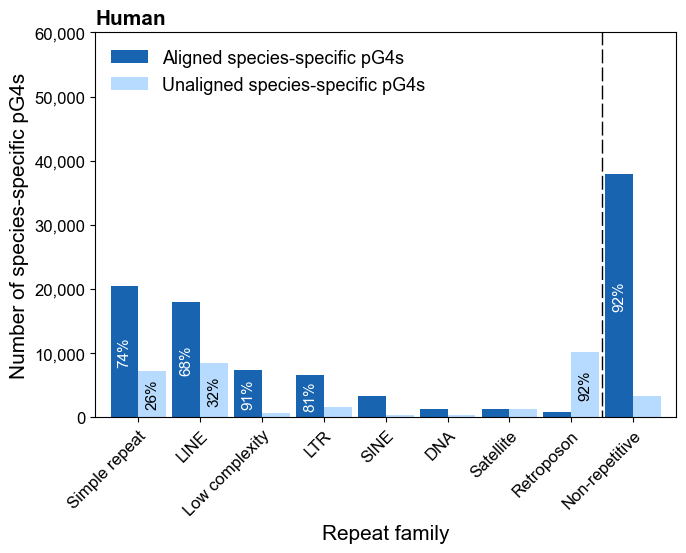

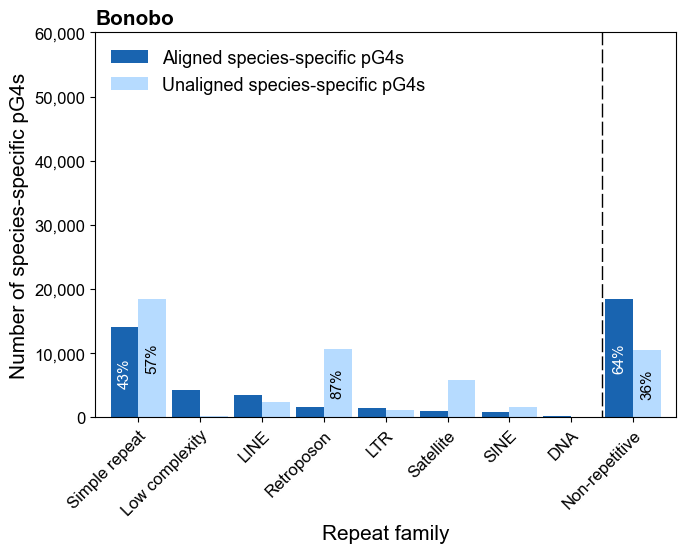

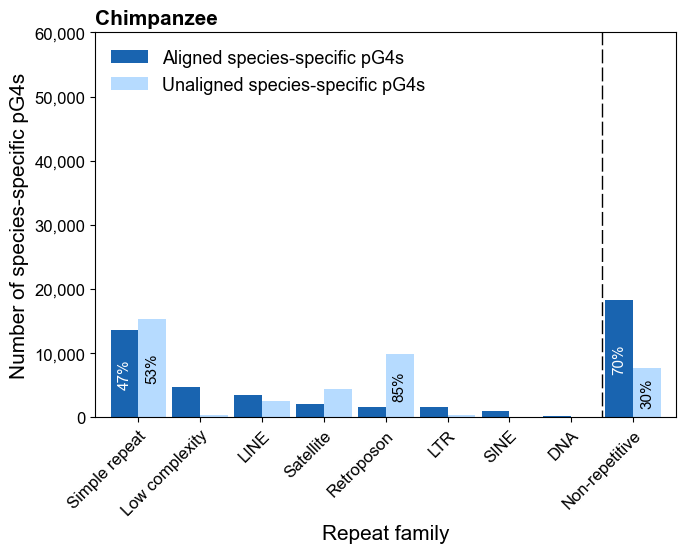

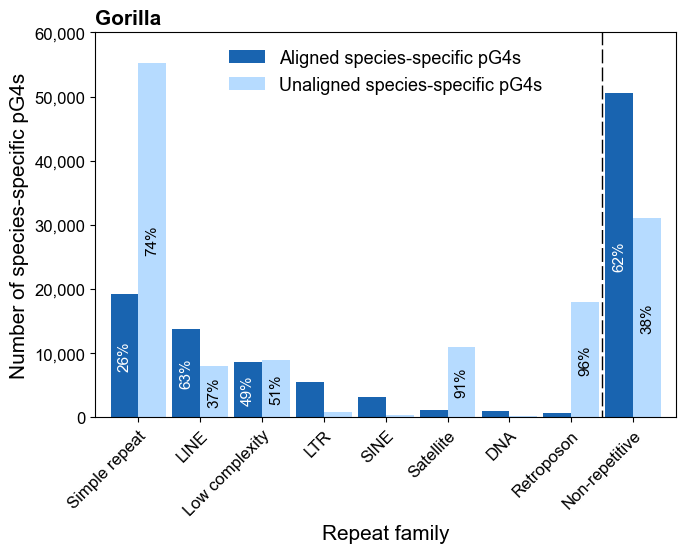

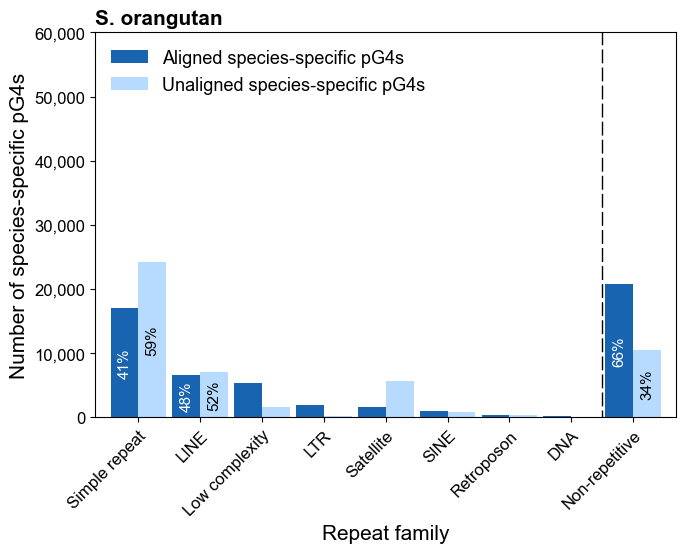

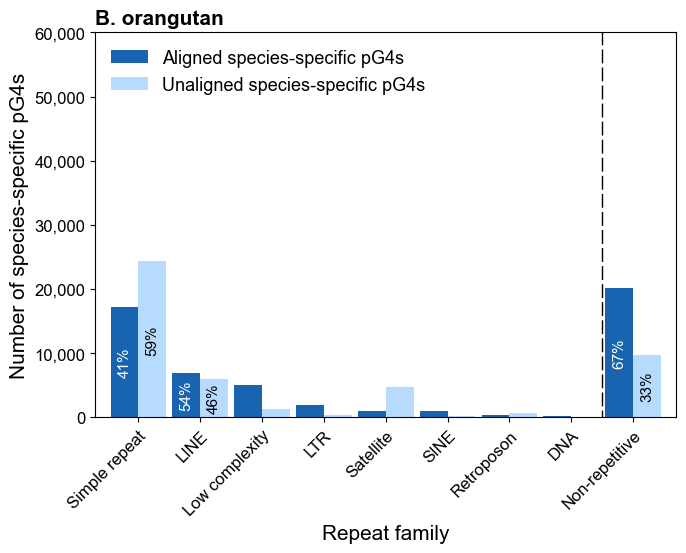

In [8]:
for species in range(1,7):
    # get the set only for the particular species
    alignedUniqueSpecies = alignedUniqueGQs[alignedUniqueGQs['species']==species].copy()
    nonAlignedUniqueSpecies = nonAlignedUniqueGQs[nonAlignedUniqueGQs['species']==species].copy()

    # drop the species column and convert to bed
    alignedUniqueSpecies.drop(columns=['species'], inplace=True)
    nonAlignedUniqueSpecies.drop(columns=['species'], inplace=True)
    alignedUnique_bed = pybedtools.BedTool.from_dataframe(alignedUniqueSpecies)
    nonAlignedUnique_bed = pybedtools.BedTool.from_dataframe(nonAlignedUniqueSpecies)

    # get the repeats and non-repeats
    repeats = pybedtools.BedTool(f'../datasets/functionalOutputs/{speciesnos[species][1]}/repeats_regions.bed.gz')
    nonrepeats = repeats.complement(g=f"../datasets/dataForAnalysis/genomeLength/{speciesnos[species][1]}/chr.genome", L=True)

    # intersect the aligned and non-aligned unique G4s with repeats and non-repeats
    alignedUnique_atRepeats = pybedtools.BedTool.intersect(alignedUnique_bed, repeats, wa=True, wb=True)
    nonAlignedUnique_atRepeats = pybedtools.BedTool.intersect(nonAlignedUnique_bed, repeats, wa=True, wb=True)
    alignedUnique_atnonRepeats = pybedtools.BedTool.intersect(alignedUnique_bed, nonrepeats, wa=True, wb=True)
    nonAlignedUnique_atnonRepeats = pybedtools.BedTool.intersect(nonAlignedUnique_bed, nonrepeats, wa=True, wb=True)

    # convert to dataframe
    alignedUnique_atRepeats = alignedUnique_atRepeats.to_dataframe()
    nonAlignedUnique_atRepeats = nonAlignedUnique_atRepeats.to_dataframe()
    alignedUnique_atnonRepeats = alignedUnique_atnonRepeats.to_dataframe()
    nonAlignedUnique_atnonRepeats = nonAlignedUnique_atnonRepeats.to_dataframe()

    # get the counts
    outofRepeats = {'family': 'Non-repetitive',
                    'counts_aligned': len(alignedUnique_atnonRepeats.iloc[:,[0,1,2,3,4,5]].drop_duplicates()),
                    'counts_nonAligned': len(nonAlignedUnique_atnonRepeats.iloc[:,[0,1,2,3,4,5]].drop_duplicates())}
    
    # merge the dataframes    
    merged = pd.merge(analyseRepeats(alignedUnique_atRepeats), analyseRepeats(nonAlignedUnique_atRepeats), on='family', suffixes=('_aligned', '_nonAligned'))
    merged = pd.concat([merged, pd.DataFrame(outofRepeats, index=[0])], ignore_index=True)
    merged['family']= merged['family'].str.replace('_',' ')
    merged['total'] = merged['counts_aligned'] + merged['counts_nonAligned']
    # remove the unknown and satellite repeats
    merged = merged[(merged['family'] != 'Unknown') & (merged['family'] != 'Satellite/Y-chromosome')
                    & (merged['family'] != 'rRNA')].copy()
    merged.rename(columns={'counts_aligned': 'Aligned species-specific pG4s', 'counts_nonAligned': 'Unaligned species-specific pG4s'}, inplace=True)
    # print(merged)

    # plot the data
    figsize=(7.5, 5)
    bar_width = 0.9
    ax = merged.plot(kind='bar', x='family', y=['Aligned species-specific pG4s', 'Unaligned species-specific pG4s'], 
                     figsize=figsize, rot=45, color=['#1964B0', '#B6DBFF'], width=bar_width, stacked=False)
    
    # inferred after looking at the plots
    ylim_max = 60000
    # add the percentage labels
    for e, i in enumerate(merged.index):
        alignedperc = round((merged['Aligned species-specific pG4s'][i]/merged['total'][i])*100, 0)
        nonalignedperc = round((merged['Unaligned species-specific pG4s'][i]/merged['total'][i])*100, 0)
        if merged['Aligned species-specific pG4s'][i] >= ylim_max * 0.1:
            ax.text(e-bar_width/4, merged['Aligned species-specific pG4s'][i]/2, f'{int(alignedperc)}%', color='white', ha='center', va='center', fontsize=11, rotation=90)
        if merged['Unaligned species-specific pG4s'][i] >= ylim_max * 0.1:
            ax.text(e+bar_width/4, merged['Unaligned species-specific pG4s'][i]/2, f'{int(nonalignedperc)}%', color='black', ha='center', va='center', fontsize=11, rotation=90)
    
    # plot the data
    plt.ylim([0, ylim_max])
    plt.ylabel(f'Number of species-specific pG4s', fontsize=15)
    plt.yticks(fontsize=12)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

    plt.xlabel('Repeat family', fontsize=15)
    plt.xticks(fontsize=12, rotation=45, ha='right', va='top', rotation_mode='anchor')
    
    plt.title(f'{speciesnos[species][2].capitalize()}', fontsize=15, loc='left', fontweight='black')
    plt.legend(frameon=False, fontsize=13)
    plt.axvline(7.5, color='black', linewidth=1, linestyle=(5, (10,3)))

    plt.savefig(f'../plots/enrichmentPlots/{speciesnos[species][1]}/alignedVsNonAligned.repeats.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'../plots/enrichmentPlots/{speciesnos[species][1]}/alignedVsNonAligned.repeats.svg', format='svg', transparent=True, bbox_inches='tight')

    plt.show()

## 2. Generate plots for aligned vs unaligned specific pG4s in great apes functional categories

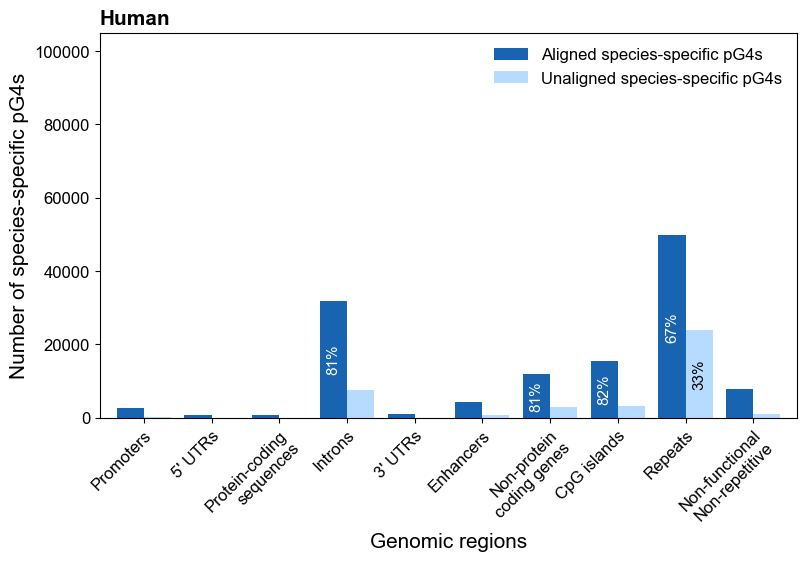

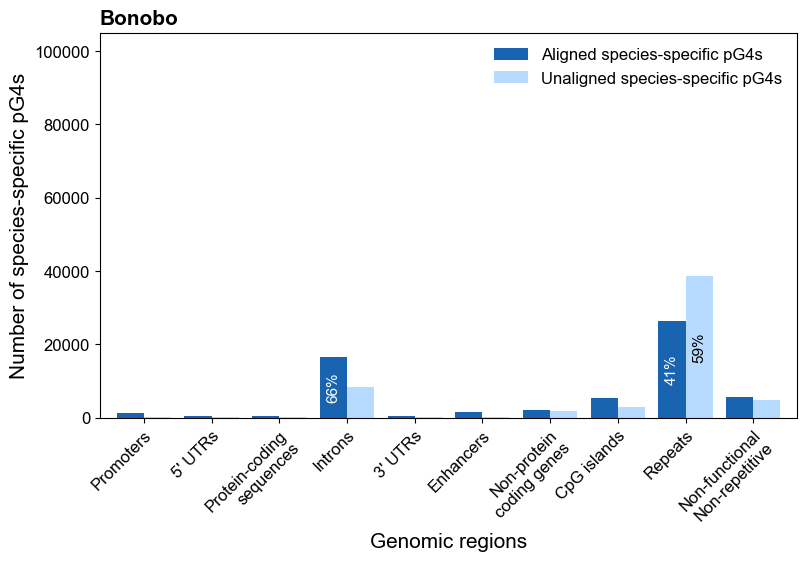

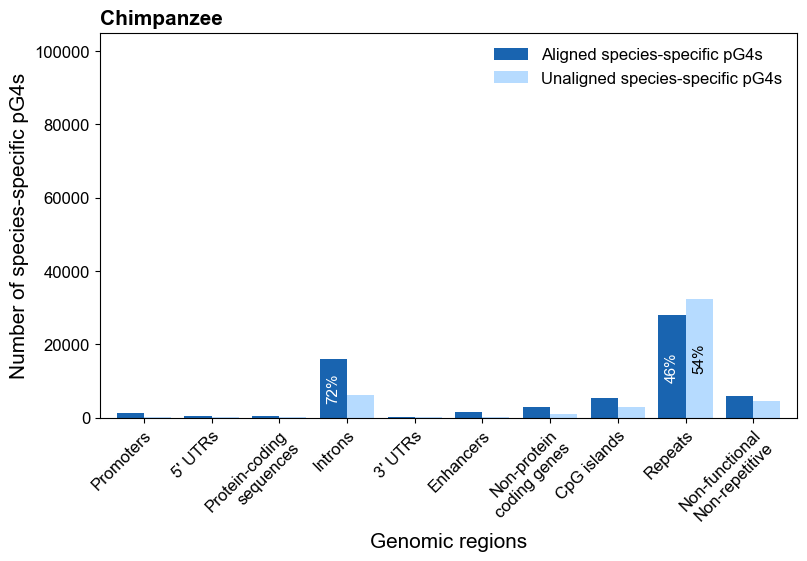

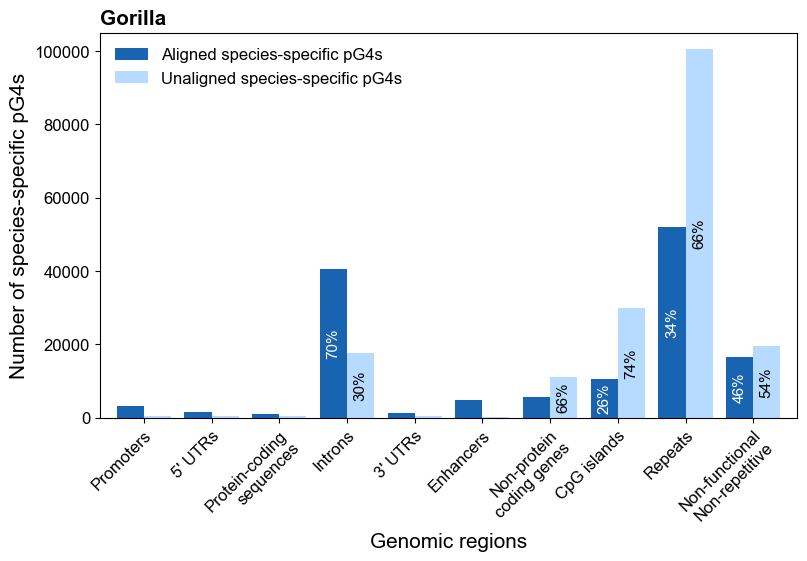

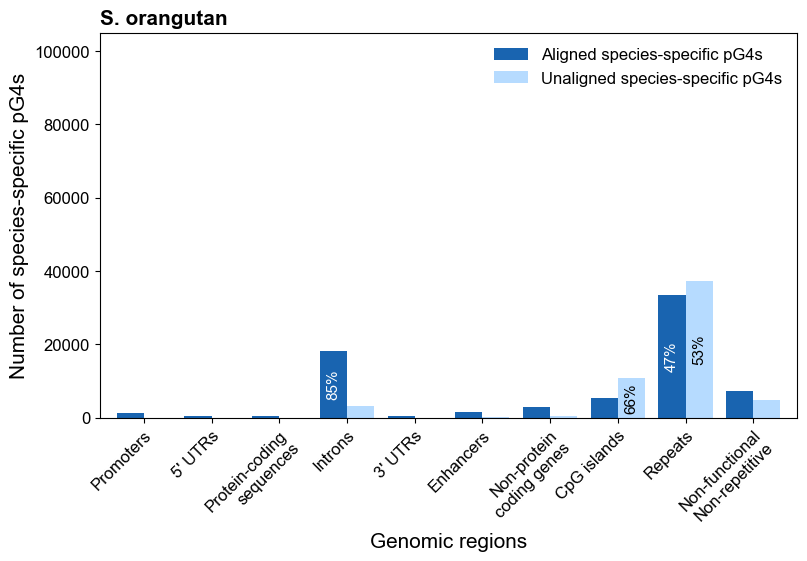

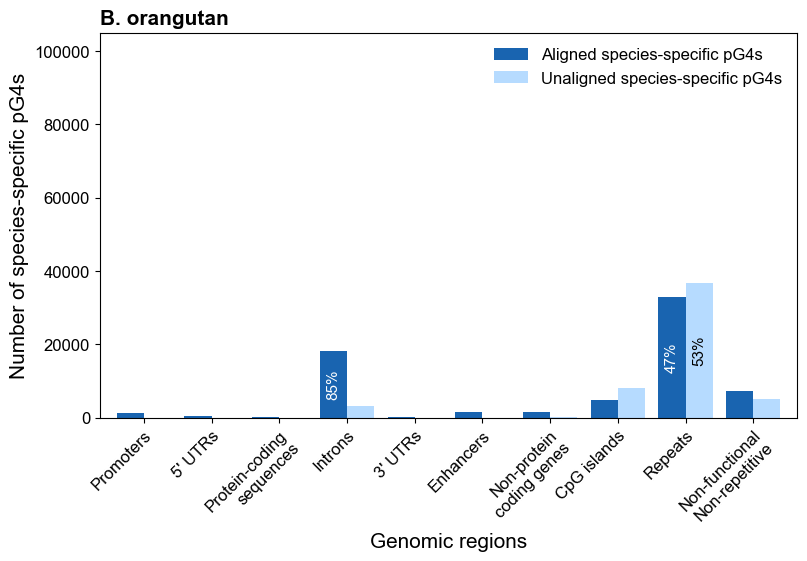

In [9]:
for species in range(1,7):
    alignedTotal = dict()
    nonAlignedTotal = dict()
    
    # get the set only for the particular species
    alignedUniqueSpecies = alignedUniqueGQs[alignedUniqueGQs['species']==species].copy()
    nonAlignedUniqueSpecies = nonAlignedUniqueGQs[nonAlignedUniqueGQs['species']==species].copy()

    # drop the species column and convert to bed
    alignedUniqueSpecies.drop(columns=['species'], inplace=True)
    nonAlignedUniqueSpecies.drop(columns=['species'], inplace=True)
    alignedUnique_bed = pybedtools.BedTool.from_dataframe(alignedUniqueSpecies)
    nonAlignedUnique_bed = pybedtools.BedTool.from_dataframe(nonAlignedUniqueSpecies)

    # get the functional regions
    for t in ["promoter","utr5","cds","intron","utr3","enhancer","npcgene","cpgi","repeats","ngnr"]:
        if t!= "cpgi":
            annots = pybedtools.BedTool(f'../datasets/functionalOutputs/{speciesnos[species][1]}/{t}_regions.bed.gz')
        elif t == "cpgi":
            cpgi_gff = pd.read_csv(f"../datasets/dataForAnalysis/geneAnnotations/{speciesnos[species][1]}/cpgIslands/chrG_cpgislands.bed.gz",header=None,sep="\t",compression='gzip')
            cpgi_gff[3] = "cpgi-." # to account for generalisation with other functional regions
            annots = pybedtools.BedTool.from_dataframe(cpgi_gff)

        # intersect the aligned and non-aligned unique G4s with functional categories
        alignedUnique_atAnnots = pybedtools.BedTool.intersect(alignedUnique_bed, annots, wa=True, wb=True)
        nonAlignedUnique_atAnnots = pybedtools.BedTool.intersect(nonAlignedUnique_bed, annots, wa=True, wb=True)

        # convert to dataframe
        alignedUnique_atAnnots = alignedUnique_atAnnots.to_dataframe()
        nonAlignedUnique_atAnnots = nonAlignedUnique_atAnnots.to_dataframe()

        # get the counts
        alignedUnique_atAnnots.drop_duplicates(subset=['chrom','start','end','strand'], inplace=True)
        nonAlignedUnique_atAnnots.drop_duplicates(subset=['chrom','start','end','strand'], inplace=True)
        alignedTotal[t] = len(alignedUnique_atAnnots)
        nonAlignedTotal[t] = len(nonAlignedUnique_atAnnots)

    # merge the dataframes
    merged = pd.DataFrame([alignedTotal, nonAlignedTotal]).T
    merged.reset_index(inplace=True)
    merged.columns = ['Functional region', 'alignedUniqueG4s', 'nonalignedUniqueG4s']
    
    # calculate the proportions
    merged['alignedProp'] = merged['alignedUniqueG4s'] / (merged['alignedUniqueG4s'] + merged['nonalignedUniqueG4s'])*100
    merged['nonAlignedProp'] = merged['nonalignedUniqueG4s'] / (merged['alignedUniqueG4s'] + merged['nonalignedUniqueG4s'])*100
    merged.rename(columns={'alignedUniqueG4s': 'Aligned species-specific pG4s', 'nonalignedUniqueG4s': 'Unaligned species-specific pG4s'}, inplace=True)

    # plot the data
    figsize=(9, 5)
    bar_width = 0.8
    merged.plot(kind='bar', x='Functional region', y=['Aligned species-specific pG4s', 'Unaligned species-specific pG4s'], figsize=figsize, rot=45, color=['#1964B0', '#B6DBFF'], width=bar_width)

    # inferred after looking at the plots
    ylim_max = 105000

    # add the percentage labels
    for i, v in enumerate(merged['Aligned species-specific pG4s']):
        percAligned = round(v/(v+merged['Unaligned species-specific pG4s'][i])*100,0)
        percunAligned = round(merged['Unaligned species-specific pG4s'][i]/(v+merged['Unaligned species-specific pG4s'][i])*100,0)
        fontsize = 11
        if v >= ylim_max * 0.1:
            plt.text(i-bar_width/4, v/2, f'{int(percAligned)}%', color='white', ha='center', va='center', rotation=90, fontsize=fontsize)
        if merged['Unaligned species-specific pG4s'][i] >= ylim_max * 0.1:
            plt.text(i+bar_width/4, merged['Unaligned species-specific pG4s'][i]/2, f'{int(percunAligned)}%', color='black', ha='center', va='center', rotation=90, fontsize=fontsize)

    plt.yticks(fontsize=12)
    plt.ylim([0, ylim_max])
    plt.ylabel(f'Number of species-specific pG4s', fontsize=15)

    plt.xticks(np.arange(10), ["Promoters", "5' UTRs", "Protein-coding\nsequences", "Introns", "3' UTRs", "Enhancers", 
                               "Non-protein\ncoding genes", "CpG islands", "Repeats", "Non-functional\nNon-repetitive"],
                                fontsize=12, rotation=45, ha='right', va='top', rotation_mode='anchor')
    plt.xlabel('Genomic regions', fontsize=15)

    plt.legend(frameon=False, fontsize=12)
    plt.title(f'{speciesnos[species][2].capitalize()}', fontsize=15, loc='left', fontweight='black')

    plt.savefig(f'../plots/enrichmentPlots/{speciesnos[species][1]}/alignedVsNonAligned.functional.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'../plots/enrichmentPlots/{speciesnos[species][1]}/alignedVsNonAligned.functional.svg', format='svg', transparent=True, bbox_inches='tight')

    plt.show()